# Аналитика в Яндекс.Афише


## Содержание:


###  [Описание проекта](#Описание_проекта)
### 1.[Изучение и предобработка данных](#Шаг_1)
### 2. [Анализ данных и расчет метрик](#Шаг_2)
#### 2.1 [Анализ продукта](#Шаг_21)
#### 2.1.1 [Оценка пользовательской активности](#Шаг_211)
#### 2.1.2 [Пользовательская сессия](#Шаг_212)
#### 2.1.3 [Retention Rate](#Шаг_213)

#### 2.2 [Анализ продаж](#Шаг_22)
#### 2.2.1 [Когортный анализ количества пользователей](#Шаг_221)
#### 2.2.2 [Оценка изменений количества пользователей по месяцам](#Шаг_222)
#### 2.2.3 [Оценка изменений среднего чека по времени жизни](#Шаг_223)
#### 2.2.4 [Расчет LTV и САС](#Шаг_224)
#### 2.3 [Анализ маркетинга](#Шаг_23)
#### 2.3.1 [Общие расходы на маркетинг](#Шаг_231)
#### 2.3.2 [Расчет ROI](#Шаг_233)

   
### 3. [Рекомендации маркетологам](#Шаг_3)  


# Описание проекта <a class="ancor" id="Описание_проекта"></a>


В __основной задаче проекта__ стоит цель помочь маркетологам оптимизировать маркетинговые затраты.  

У нас в распоряжении есть данные от __Яндекс.Афиши__ с июня __2017__ по конец мая __2018 года__:
1. лог сервера с данными о посещениях сайта Яндекс.Афиши,
2. выгрузка всех заказов за этот период,
3. статистика рекламных расходов.  

Мы изучим:
1. как люди пользуются продуктом,
2. когда они начинают покупать,
3. сколько денег приносит каждый клиент
4. когда клиент окупается.

# Изучение и предобработка данных <a class="ancor" id="Шаг_1"></a>

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
#read_csv
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

### Описание данных

---

__Таблица visits__(лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

---

__Таблица orders__ (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа
___

__Таблица costs__ (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день
___

In [3]:
#рассмотрим каждую из таблиц на наличие пропусков и оптимизации
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06


In [4]:
#приведение названия столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
#переименуем названия столбцов, чтобы избавиться от пробелов в них
visits.columns = ['uid', 'device', 'end_ts', 'source_id', 'start_ts']

In [5]:
#откорректируем тип данных для дат
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format ='%d.%m.%Y %H:%M')

In [6]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format ='%d.%m.%Y %H:%M')

In [7]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
#последняя строка заказа пришлась на 1 июня 2018 г
#заменим ее на 31 мая, т.к. отчетный период у нас до мая
#и расходы до мая 2018 г.
#изменение заказа не критично на несколько секунд
orders['Buy Ts'] = orders['Buy Ts'].replace('2018-06-01 00:02:00', '2018-05-31 23:59:00')
orders['Buy Ts']

0        2017-06-01 00:10:00
1        2017-06-01 00:25:00
2        2017-06-01 00:27:00
3        2017-06-01 00:29:00
4        2017-06-01 07:58:00
                ...         
50410    2018-05-31 23:50:00
50411    2018-05-31 23:50:00
50412    2018-05-31 23:54:00
50413    2018-05-31 23:56:00
50414    2018-05-31 23:59:00
Name: Buy Ts, Length: 50415, dtype: object

In [9]:
#приведение названия столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()
#переименуем названия столбцов, чтобы избавиться от пробелов в них
orders.columns = ['buy_ts', 'revenue', 'uid']
#откорректируем тип данных для дат
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [10]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [11]:
#откорректируем тип данных для дат
costs['dt'] = pd.to_datetime(costs['dt'])

In [12]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [13]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:59:00
Name: buy_ts, dtype: object

In [14]:
visits['start_ts'].describe()

count                  358532
unique                 223977
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [15]:
#теперь у нас все даты в одном диапазоне

# Анализ данных и расчет метрик <a class="ancor" id="Шаг_2"></a>

## Анализ продукта  <a class="ancor" id="Шаг_21"></a>

## Оценка пользовательской активности <a class="ancor" id="Шаг_211"></a>
### Расчет DAU, WAU, MAU

Сколько людей пользуются в день, неделю, месяц?

Для ответа на этот вопрос расчитаем количество уникальных пользователей в день, неделю и месяц для разных типов устройств и рекламных источников

In [16]:
#добавим неделю, месяц и год новыми колонками
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year

In [17]:
#оценка пользовательской активности за день и расчет dau по устройствам
dau_total_device = visits.pivot_table(index = 'session_date', columns = 'device', values = 'uid', aggfunc='nunique')
dau_total_device.describe()

device,desktop,touch
count,364.000000,363.000000
mean,659.217033,252.834711
std,284.771311,102.026024
min,1.000000,46.000000
25%,421.750000,173.500000
50%,649.000000,264.000000
75%,877.000000,322.000000
max,2605.000000,776.000000


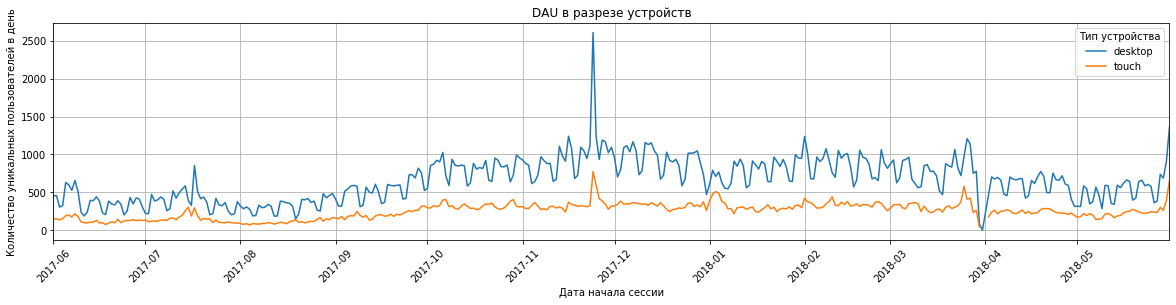

In [18]:
dau_total_device.plot(rot=45, grid=True, figsize = (20,4), title='DAU в разрезе устройств')
plt.xlabel('Дата начала сессии')
plt.ylabel('Количество уникальных пользователей в день')
plt.legend( title='Тип устройства')
plt.show()

In [19]:
dau_total_device[dau_total_device['desktop'] == dau_total_device['desktop'].max()]

device,desktop,touch
session_date,,
2017-11-24,2605.0,776.0


Количество уникальных пользователей за день сильно отличается на разных типах устройств. Пользователи с компьютера(659) гораздо активнее, пользователей телефонов(252).  
На графике заметен пик 24 ноября  2017 года, количество пользователей резко выделяется на фоне остального периода, возможно это связано с каким-то событием.
Также на графике заметно, что линии цикличны, то есть количество пользователей увеличивается и идет на спад в период какого-то короткого времени, предположительно недели. Проверим это в дальнейшем.

In [20]:
#оценка пользовательской активности за и расчет dau по рекламным источникам
dau_total_source_id = visits.pivot_table(index = 'session_date', columns = 'source_id', values = 'uid', aggfunc='nunique')
dau_total_source_id.describe()

source_id,1,2,3,4,5,6,7,9,10
count,364.000000,363.000000,363.000000,363.000000,363.000000,6.0,34.000000,363.000000,363.000000
mean,80.524725,120.628099,232.790634,275.385675,175.603306,1.0,1.058824,36.074380,26.022039
std,41.802724,59.024267,96.593871,120.735476,64.861367,0.0,0.238833,46.876793,17.854679
min,1.000000,17.000000,32.000000,32.000000,32.000000,1.0,1.000000,1.000000,1.000000
25%,51.000000,79.500000,153.000000,167.500000,127.500000,1.0,1.000000,9.500000,14.000000
50%,79.000000,119.000000,236.000000,294.000000,169.000000,1.0,1.000000,22.000000,22.000000
75%,102.000000,150.500000,302.000000,371.000000,214.500000,1.0,1.000000,51.500000,34.500000
max,483.000000,599.000000,930.000000,714.000000,392.000000,1.0,2.000000,554.000000,132.000000


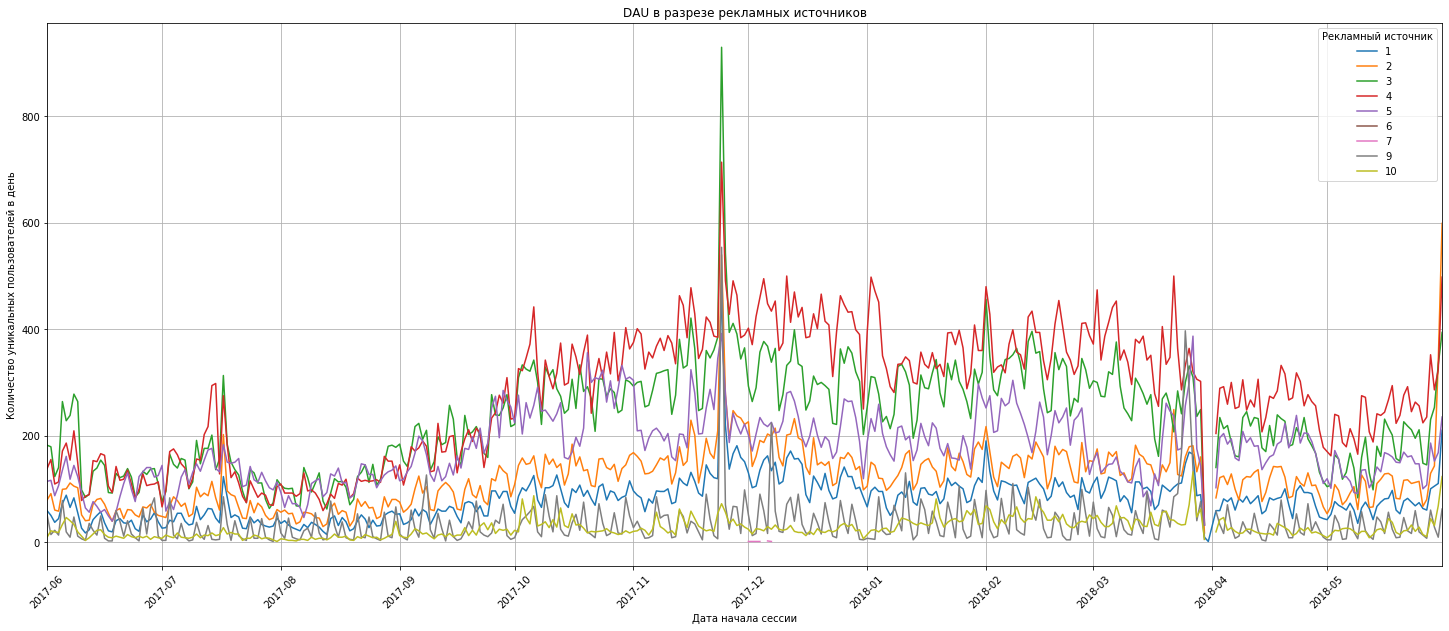

In [21]:
dau_total_source_id.plot(rot=45, grid=True, figsize = (25,10), title='DAU в разрезе рекламных источников')
plt.xlabel('Дата начала сессии')
plt.ylabel('Количество уникальных пользователей в день')
plt.legend( title='Рекламный источник')
plt.show()

In [22]:
dau_total_source_id[dau_total_source_id[3] == dau_total_source_id[3].max()]

source_id,1,2,3,4,5,6,7,9,10
session_date,,,,,,,,,
2017-11-24,483.0,540.0,930.0,714.0,392.0,NaN,NaN,554.0,72.0


In [23]:
visits.groupby('source_id')['uid'].nunique().reset_index().sort_values('uid', ascending = False)

,source_id,uid
3,4,83525
2,3,74756
4,5,56974
1,2,26245
0,1,18999
7,9,9264
8,10,8067
6,7,34
5,6,6


Количество уникальных пользователей за день сильно отличается по рекламным источникам. Тренды схожи с предыдущим графиком, здесь можно выделить что больше всего пользователей пришли из рекламного источника 3 и 4

In [24]:
#оценка пользовательской активности и расчет wau по устройствам
wau_total_device = visits.pivot_table(index = ['session_year','session_week'], 
                                      columns = 'device', 
                                      values = 'uid', 
                                      aggfunc='nunique')
wau_total_device.describe()

device,desktop,touch
count,53.000000,53.000000
mean,4129.377358,1634.735849
std,1508.790336,591.583733
min,1450.000000,584.000000
25%,2945.000000,1208.000000
50%,4061.000000,1724.000000
75%,5346.000000,2126.000000
max,7979.000000,2784.000000


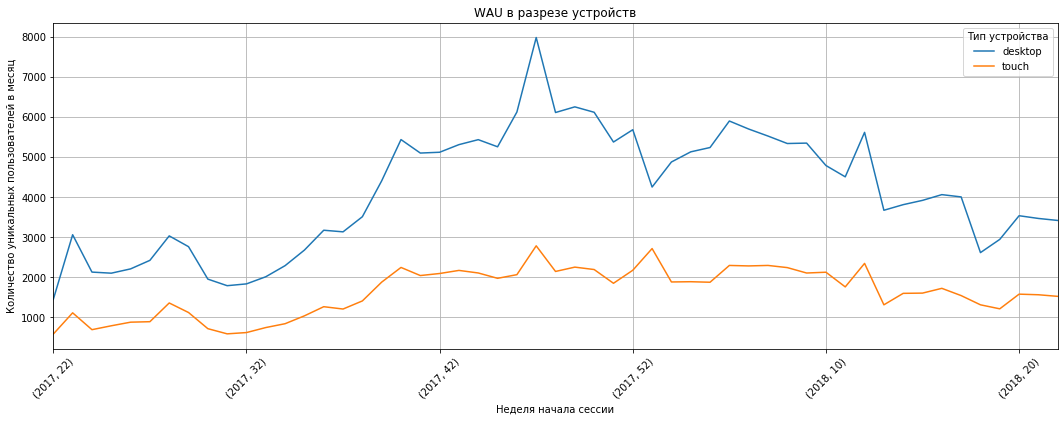

In [25]:
wau_total_device.plot(rot=45, grid=True, figsize = (18,6), title='WAU в разрезе устройств')
plt.xlabel('Неделя начала сессии')
plt.ylabel('Количество уникальных пользователей в месяц')
plt.legend( title='Тип устройства')

plt.show()

In [26]:
wau_total_source_id= visits.pivot_table(index = ['session_year','session_week'], 
                                      columns = 'source_id', 
                                      values = 'uid', 
                                      aggfunc='nunique')
wau_total_source_id.describe()

source_id,1,2,3,4,5,6,7,9,10
count,53.000000,53.000000,53.000000,53.000000,53.000000,6.0,27.000000,53.000000,53.000000
mean,463.377358,715.245283,1565.547170,1828.886792,1167.358491,1.0,1.333333,238.471698,166.509434
std,191.331592,267.083962,590.253647,770.937757,392.524134,0.0,0.733799,139.406931,83.715549
min,162.000000,259.000000,614.000000,510.000000,395.000000,1.0,1.000000,98.000000,25.000000
25%,336.000000,538.000000,1143.000000,1133.000000,857.000000,1.0,1.000000,165.000000,99.000000
50%,493.000000,717.000000,1480.000000,1831.000000,1164.000000,1.0,1.000000,214.000000,152.000000
75%,568.000000,885.000000,2045.000000,2526.000000,1486.000000,1.0,1.000000,267.000000,246.000000
max,1131.000000,1489.000000,3241.000000,3054.000000,2005.000000,1.0,4.000000,833.000000,339.000000


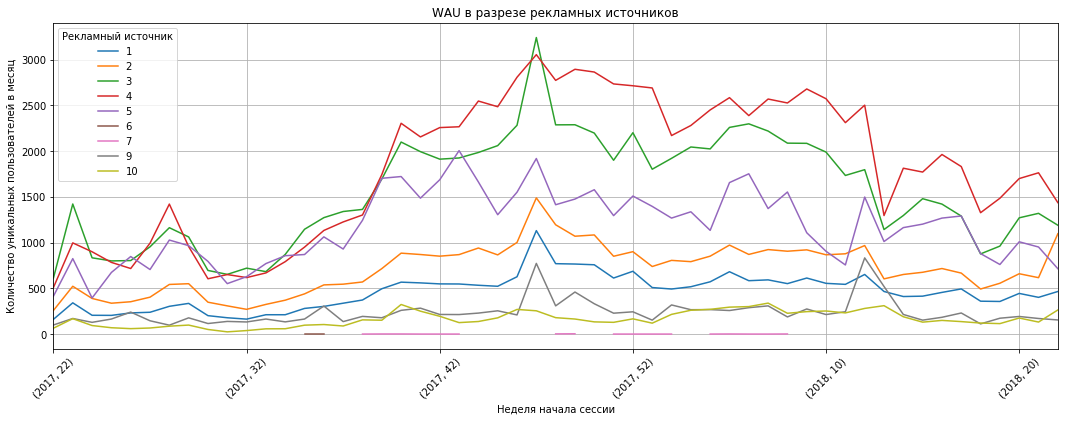

In [27]:
wau_total_source_id.plot(rot=45, grid=True, figsize = (18,6), title='WAU в разрезе рекламных источников')
plt.xlabel('Неделя начала сессии')
plt.ylabel('Количество уникальных пользователей в месяц')
plt.legend( title='Рекламный источник')

plt.show()

Анализируя пользователей за неделю, можно сказать, что наблюдаются цикличность. Возможно это связано с какими-то датами мероприятий, на которые покупались билеты.  
Также стоит заметить, что рекламные источники 6 и 7 почти не приносят пользы.

In [28]:
#оценка пользовательской активности и расчет mau по устройствам
mau_total_device = visits.pivot_table(index = ['session_year','session_month'], 
                                      columns = 'device', 
                                      values = 'uid', 
                                      aggfunc='nunique')
mau_total_device.describe()

device,desktop,touch
count,12.000000,12.000000
mean,16724.500000,6825.166667
std,5533.815099,2200.919966
min,8611.000000,3131.000000
25%,12667.000000,5314.250000
50%,17208.500000,7474.500000
75%,20752.000000,8752.000000
max,24439.000000,8911.000000


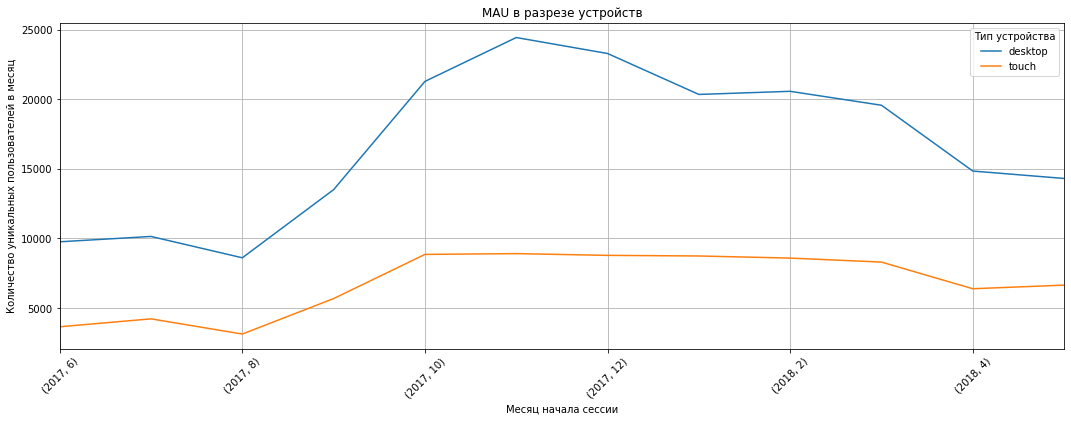

In [29]:
mau_total_device.plot(rot=45, grid=True, figsize = (18,6), title='MAU в разрезе устройств')
plt.xlabel('Месяц начала сессии')
plt.ylabel('Количество уникальных пользователей в месяц')
plt.legend( title='Тип устройства')

plt.show()

In [30]:
mau_total_source_id= visits.pivot_table(index = ['session_year','session_month'], 
                                      columns = 'source_id', 
                                      values = 'uid', 
                                      aggfunc='nunique')
mau_total_source_id.describe()

source_id,1,2,3,4,5,6,7,9,10
count,12.000000,12.000000,12.000000,12.000000,12.000000,6.0,12.000000,12.000000,12.000000
mean,1818.583333,2750.000000,6757.333333,7764.416667,5017.500000,1.0,2.833333,986.250000,706.833333
std,668.309735,914.391203,2291.614807,3068.052787,1418.148441,0.0,2.329000,365.163257,300.822458
min,794.000000,1272.000000,3414.000000,3128.000000,2903.000000,1.0,1.000000,562.000000,244.000000
25%,1306.500000,2039.000000,5063.500000,5059.000000,3960.000000,1.0,1.000000,750.750000,483.000000
50%,1938.500000,3061.000000,6723.000000,8413.500000,4923.000000,1.0,2.000000,908.500000,699.000000
75%,2199.750000,3344.750000,8569.000000,9917.000000,6018.500000,1.0,3.250000,1102.000000,925.250000
max,2790.000000,4190.000000,10185.000000,11786.000000,7525.000000,1.0,9.000000,1772.000000,1166.000000


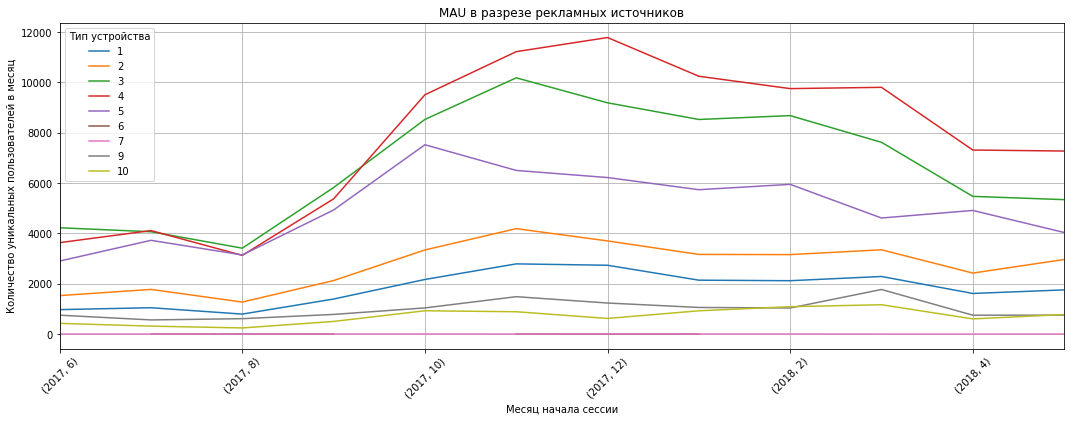

In [31]:
mau_total_source_id.plot(rot=45, grid=True, figsize = (18,6), title='MAU в разрезе рекламных источников')
plt.xlabel('Месяц начала сессии')
plt.ylabel('Количество уникальных пользователей в месяц')
plt.legend( title='Тип устройства')

plt.show()

На графике количества уникальных пользователей по месяцам уже можно увидить целостную картину за период. С осени 2017 года идет рост активности пользователей и приток с различных рекламных источников. Заканчивается данный тренд в конце года.  

В 2018 году зимой и весной идет плавный спад. 

В целом можно сделать вывод, что пользователи активнее ведут себя осенью и зимой, а весно и летом идет отток пользователей.

## Пользовательская сессия <a class="ancor" id="Шаг_212"></a>

In [32]:
#посчитаем количество сессий в день в целом и на одного пользователя

sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

,n_sessions,n_users,sess_per_user
session_date,,,
2017-06-01,661,605,1.092562
2017-06-02,653,608,1.074013
2017-06-03,476,445,1.069663
2017-06-04,508,476,1.067227
2017-06-05,887,820,1.081707
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1155,1039,1.111646
2018-05-29,1033,948,1.089662


In [33]:
print('В среднем в день совершается {:.2f} сессий'.format(sessions_per_user.n_sessions.mean()))
print('Каждый пользователь совершает в среднем по {:.2f} сессий'.format(sessions_per_user.sess_per_user.mean()))


В среднем в день совершается 984.98 сессий
Каждый пользователь совершает в среднем по 1.08 сессий


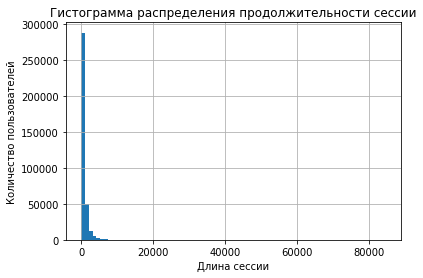

In [34]:
#Найдем продолжительность сессий и построим гистограмму
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins=80)
visits['session_duration_sec'].describe()
plt.xlabel('Длина сессии')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма распределения продолжительности сессии')

plt.show()

In [35]:
#Найдём ASL — посчитаем длину всех сессий и вычислим среднее
ASL = visits['session_duration_sec'].mode()
ASL

0    60
dtype: int64

На гистограмме видны  значительные выбросы, что говорит о том, что среднее значение продолжительности сессии было бы не информативным. Мы можем использовать моду, чтобы узнать какая продолжительность сессии встречается чаще всего. 
Это либо 0 либо 60 сек.
Можно сделать предположение, что есть какие-то проблемы, которые объясняют такое количество сессий длительностью 0 сек., например, сайт плохо отображается в мобильной версии — и все сессии со смартфонов и планшетов очень короткие. 

Сгрупируем данный по типам устройств и рекламных источников, чтобы увидеть более подробное описание.

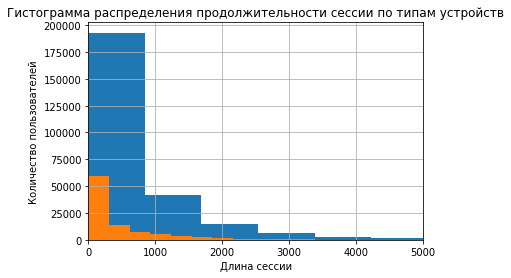

In [36]:
#гистограмма в разрезе типов устройств
visits.groupby('device')['session_duration_sec'].hist(bins=100);
plt.xlabel('Длина сессии')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма распределения продолжительности сессии по типам устройств')
plt.xlim(0,5000)
plt.show()

In [37]:
#Найдем продолжительность сессий по типу устройства
ASL_device = visits.groupby('device')['session_duration_sec'].median().reset_index()
ASL_device

,device,session_duration_sec
0,desktop,360
1,touch,180


По типам устройств на гистограмме видно, что распределения схожи между собой, но на компьютерах сессии продолжительней и чаще пользуются сайтом с компьютера

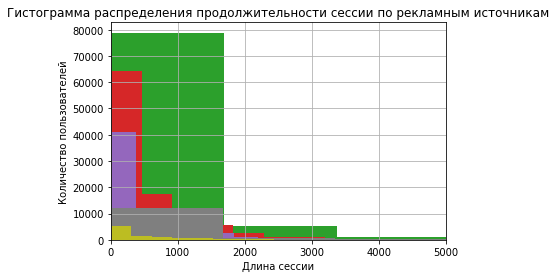

In [38]:
visits.groupby('source_id')['session_duration_sec'].hist(bins=50);
plt.xlabel('Длина сессии')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма распределения продолжительности сессии по рекламным источникам')
plt.xlim(0,5000)

plt.show()

In [39]:
#Найдем продолжительность сессий по рекламным источникам
ASL_source_id = visits.groupby('source_id')['session_duration_sec'].median().reset_index()
ASL_source_id

,source_id,session_duration_sec
0,1,600
1,2,420
2,3,240
3,4,240
4,5,240
5,6,420
6,7,180
7,9,240
8,10,300


Наиболее продолжительные сессии из источников 1,2,6

In [40]:
#посчитаем количество сессий в день на одного пользователя по типам устройств

sessions_per_user_device = visits.pivot_table(index = ['session_date','device'],  
                                      values = 'uid', 
                                      aggfunc={'uid': ['count','nunique']})
sessions_per_user_device.columns = ['n_sessions', 'n_users']
sessions_per_user_device['sess_per_user'] = sessions_per_user_device['n_sessions'] / sessions_per_user_device['n_users']

sessions_per_user_device.groupby('device')['sess_per_user'].describe().T

device,desktop,touch
count,364.000000,363.000000
mean,1.086339,1.048874
std,0.022218,0.021310
min,1.000000,1.000000
25%,1.073095,1.035542
50%,1.086585,1.047619
75%,1.099252,1.058387
max,1.200000,1.177326


In [41]:
#посчитаем количество на одного пользователя по рекламным источникам

sessions_per_user_source_id = visits.pivot_table(index = ['session_date', 'source_id'], 
                                      values = 'uid', 
                                      aggfunc={'uid': ['count','nunique']})
sessions_per_user_source_id.columns = ['n_sessions', 'n_users']
sessions_per_user_source_id['sess_per_user'] = sessions_per_user_source_id['n_sessions'] / sessions_per_user_source_id['n_users']
sessions_per_user_source_id.groupby('source_id')['sess_per_user'].describe().T


source_id,1,2,3,4,5,6,7,9,10
count,364.000000,363.000000,363.000000,363.000000,363.000000,6.0,34.0,363.000000,363.000000
mean,1.148896,1.079590,1.010352,1.015416,1.045450,1.0,1.0,1.011411,1.047309
std,0.067526,0.035966,0.007776,0.010094,0.022155,0.0,0.0,0.025844,0.068151
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000
25%,1.100000,1.054545,1.004598,1.008602,1.031514,1.0,1.0,1.000000,1.000000
50%,1.146087,1.080460,1.009390,1.014815,1.042373,1.0,1.0,1.000000,1.012346
75%,1.189480,1.105264,1.015083,1.020879,1.058621,1.0,1.0,1.011976,1.074176
max,1.473684,1.216418,1.038095,1.088235,1.205882,1.0,1.0,1.166667,1.413793


## Retention Rate <a class="ancor" id="Шаг_213"></a>

In [42]:
#Расчёт Retention Rate
user_activity = visits[['device','source_id','uid', 'session_date']].copy()
user_activity.columns = ['device','source_id','uid', 'activity_date']
user_activity['activity_date'] = pd.to_datetime(user_activity['activity_date'])
#получим дату первого заказа
first_activity_date = user_activity.groupby(['uid'])['activity_date'].min()
first_activity_date.name = 'first_activity_date'
user_activity = user_activity.join(first_activity_date,on='uid')

In [43]:
user_activity['activity_month'] = user_activity['activity_date'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

In [44]:
#добавим возраст когорты
user_activity['cohort_lifetime'] = user_activity['activity_month'] - user_activity['first_activity_month']
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')

In [45]:
#сгрупируем по месячным когортам
cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [46]:
#вычислим размер когорты
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

In [47]:
#расчет удержания
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [48]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',values='retention',aggfunc='sum')

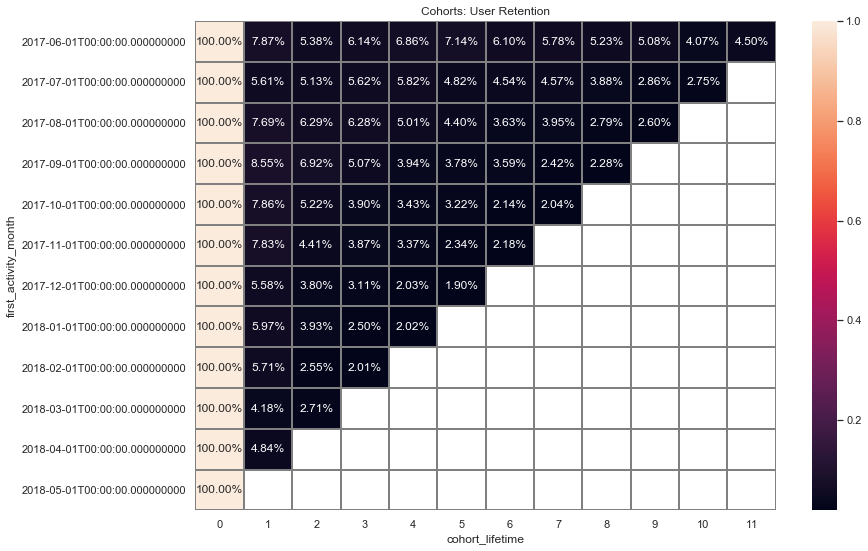

In [49]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

Retention Rate очень низкий.
То есть пользователь приобретает билет чаще всего единожды и очень мало таких людей, которые постоянно пользуются услугами Яндекс.Афиши.

Разделим когорты не по месяцам, а по типам устройства и рекламным источникам, чтобы увидеть где больше процент удержания


In [50]:
#разделим когорты по типам устройств
cohorts_device = user_activity.groupby(['device','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [51]:
initial_users_count_device = cohorts_device[cohorts_device['cohort_lifetime'] == 0][['device','uid']]
initial_users_count_device = initial_users_count_device.rename(columns={'uid':'cohort_users'})

In [52]:
cohorts_device = cohorts_device.merge(initial_users_count_device,on='device')

In [53]:
cohorts_device['retention'] = cohorts_device['uid']/cohorts_device['cohort_users']

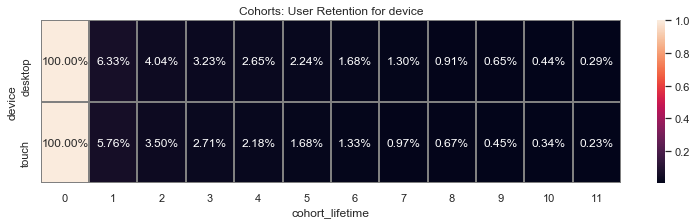

In [54]:
retention_pivot_device = cohorts_device.pivot_table(index='device',
                                      columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 3))
plt.title('Cohorts: User Retention for device')
ax = sns.heatmap(retention_pivot_device, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

In [55]:
#по рекламным источникам
cohorts_source_id = user_activity.groupby(['source_id','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count_source_id = cohorts_source_id[cohorts_source_id['cohort_lifetime'] == 0][['source_id','uid']]
initial_users_count_source_id = initial_users_count_source_id.rename(columns={'uid':'cohort_users'})

In [56]:
cohorts_source_id = cohorts_source_id.merge(initial_users_count_source_id,on='source_id')

In [57]:
cohorts_source_id['retention'] = cohorts_source_id['uid']/cohorts_source_id['cohort_users']

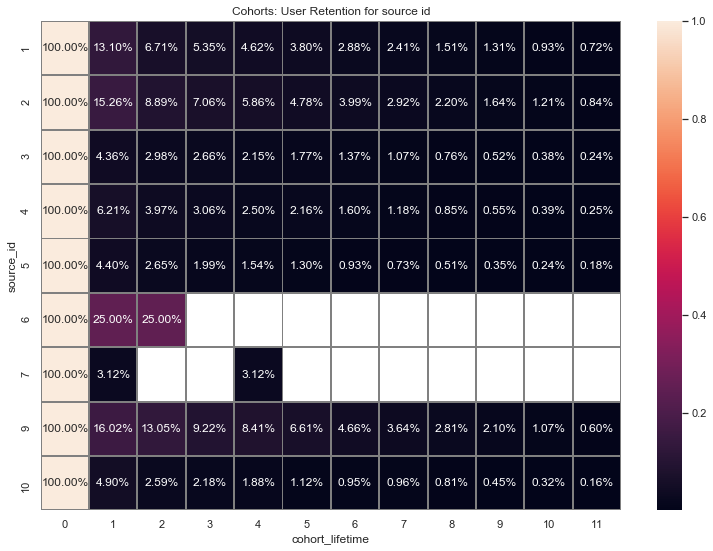

In [58]:
retention_pivot_source_id = cohorts_source_id.pivot_table(index='source_id',
                                      columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention for source id')
ax = sns.heatmap(retention_pivot_source_id, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

## Анализ продаж  <a class="ancor" id="Шаг_22"></a>

## Когортный анализ количества покупок <a class="ancor" id="Шаг_221"></a>

Для анализа продаж нам необходимо добавить тип устройства и рекламный источник. Т.к. один пользователь мог заходить с разных устройств и возвращаться с разных рекламных источников, примем что наибольший вес для принятия решения о покупки был у первого рекламного источника и устройства, с которого он заходил в первый раз. 

Составим профиль пользователя, где будет собрана информация о пользователе

In [59]:
#построим профили пользователей(asquisition - приобретение)
users = (visits.sort_values(by = ['uid','start_ts'])
         .groupby('uid')
         .agg({'start_ts':'first','source_id':'first','device':'first', 'session_date':'first'})
         .rename(columns={'start_ts':'asquisition_ts', 'session_date':'asquisition_date'}))
users['asquisition_month'] = users['asquisition_date'].astype('datetime64[M]')

In [60]:
#в расходах переименуем столбцы для дальнейшего соединения, дата расхода = дата приобретения
#и прикрепим по дате и рекламному источник
costs.columns = ['source_id', 'asquisition_date', 'costs']

In [61]:
users = (users.reset_index()
         .set_index(['source_id', 'asquisition_date'])
         .join(costs.set_index(['source_id', 'asquisition_date']), how ='left'))

In [63]:
#добавляем стоимость приобретения индивидуального пользователя
user_cost = (users.groupby(['source_id', 'asquisition_date'])
             .agg({'device':'count', 'costs':'max'})
             .rename(columns = {'device':'user'})) #количество пользователей
user_cost['asquisition_cost'] = user_cost['costs']/user_cost['user']

users = users.join(user_cost[['asquisition_cost']], how = 'left').reset_index()
users = users.set_index('uid')[['asquisition_ts', 'asquisition_date', 'asquisition_month', 
                                'source_id','device', 'asquisition_cost']]

In [64]:
#платящий пользователь или нет
users= users.join(orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns = {'buy_ts':'first_purchase_dt'}),how='left')

In [65]:
users['payer'] = ~users['first_purchase_dt'].isna() #была покупка или нет
users['first_purchase_month'] = users['first_purchase_dt'].astype('datetime64[M]') #первый месяц покупки
users = users.reset_index()

,uid,asquisition_ts,asquisition_date,asquisition_month,source_id,device,asquisition_cost,first_purchase_dt,payer,first_purchase_month
0,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.671111,2017-09-11 00:06:00,True,2017-09-01
1,618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.671111,NaT,False,NaT
2,1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.671111,2017-06-01 09:23:00,True,2017-06-01
3,1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.671111,2017-06-01 16:47:00,True,2017-06-01
4,1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.671111,NaT,False,NaT
...,...,...,...,...,...,...,...,...,...,...
228164,17550479715346067160,2018-05-31 22:00:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,False,NaT
228165,17715613363403416471,2018-05-31 03:30:00,2018-05-31,2018-05-01,10,desktop,0.177778,NaT,False,NaT
228166,18076428844159112818,2018-05-31 17:47:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,False,NaT
228167,18238279803055794091,2018-05-31 15:52:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,False,NaT


In [66]:
cohort_grouped = users.groupby('first_purchase_month').agg({'uid':'nunique'})
cohort_grouped

,uid
first_purchase_month,
2017-06-01,2023
2017-07-01,1923
2017-08-01,1370
2017-09-01,2581
2017-10-01,4340
2017-11-01,4081
2017-12-01,4383
2018-01-01,3373
2018-02-01,3651


In [67]:
cohort_grouped_device = (users.groupby('device')
                         .agg({'uid':'nunique', 'payer':'sum'})#payer: sum суммирует только если payer == True
                         .sort_values(by='uid', ascending = False))
cohort_grouped_device

,uid,payer
device,,
desktop,160799,29215.0
touch,67370,7308.0


In [68]:
cohort_grouped_source_id = (users.groupby('source_id')
                            .agg({'uid':'nunique', 'payer':'sum'})
                            .sort_values(by='uid', ascending = False))
cohort_grouped_source_id

,uid,payer
source_id,,
4,72330,10280.0
3,66107,10464.0
5,49266,6960.0
2,17607,3497.0
1,9490,2920.0
10,6901,1327.0
9,6434,1074.0
7,32,1.0
6,2,0.0


Мы выполнили первый взгляд на размеры когорт по разным признакам: месяца, устройства и источники рекламы. И уже можно увидеть, что корорта desctop больше, когорты touch в 4 раза.
По рекламным источникам также можно выделить самые крупные: 4,3,5.

Далее посмотрим как изменялось количество этих когорт по месяцам

## Оценка изменений количества покупок по месяцам <a class="ancor" id="Шаг_222"></a>

In [69]:
#сгруппируем данные помесячно
orders_cohorts = users.pivot_table(index='asquisition_month',
    columns='first_purchase_month',
    values='uid',
    aggfunc='nunique')

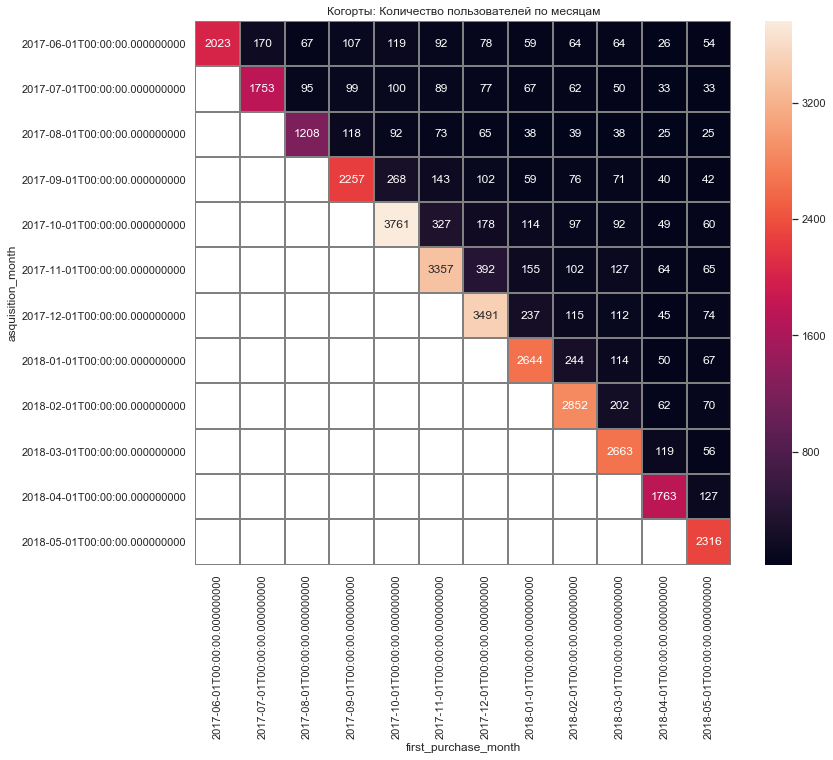

In [70]:
sns.set(style='white')
plt.figure(figsize=(12, 10))
plt.title('Когорты: Количество покупок по месяцам')
ax = sns.heatmap(orders_cohorts, annot=True, fmt='.0f', linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

## Оценка изменений количества покупок по типам устройств 

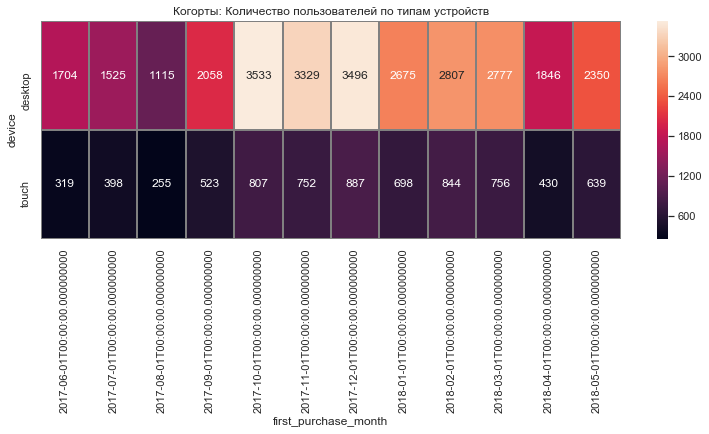

In [71]:
orders_device = users.pivot_table(index='device',
    columns='first_purchase_month',
    values='uid',
    aggfunc='nunique')

sns.set(style='white')
plt.figure(figsize=(13, 4))
plt.title('Когорты: Количество покупок по типам устройств')
ax = sns.heatmap(orders_device, annot=True, fmt='.0f', linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

## Оценка изменений количества покупок по рекламному источнику 

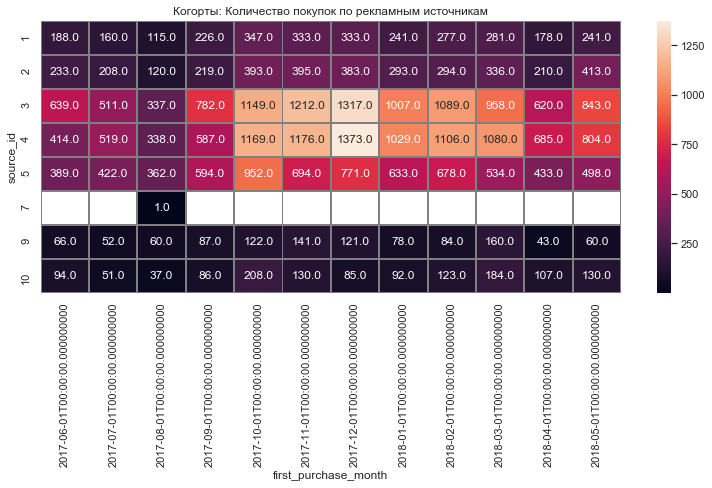

In [72]:
orders_source_id = users.pivot_table(index='source_id',
    columns='first_purchase_month',
    values='uid',
    aggfunc='nunique')

sns.set(style='white')
plt.figure(figsize=(13, 5))
plt.title('Когорты: Количество покупок по рекламным источникам')
ax = sns.heatmap(orders_source_id, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

Количество покупок первые три месяца по каждой следующей когорте меньше предыдущей. Это логично, ведь более старые когорты существуют дольше, и пользователи из них совершали заказы в течение бóльшего времени.

Исключение составляет когорты с сентября по декабрь, в этот период наблюдается большой рост покупок пользователей на сайте.

Но после 12.2017 количество пользователей, составляющих каждую когорту, начинает убывать с каждым месяцем. Значит, Яндекс. Афишу со временем посещают всё меньше и меньше новых пользователей, совершающих покупки.

Количество покупок с компьютера намного превышает покупки с телефона. Что подтверждает выводы по визитам пользователей на сайт.
Наибольшее количество покупок принес 3 и 4 источник.
7,9,10 источник наоборот в аутсайдерах.
Также заметим, что покупки с 6 источника совсем не совершались, хотя показатель Retention Rate  выше остальных. 

## Оценка изменений среднего чека по времени жизни <a class="ancor" id="Шаг_223"></a>

In [73]:
#данные по заказам
report = orders.set_index('uid').join(users.set_index('uid'), how ='left')[['asquisition_month','source_id','device', 'first_purchase_month', 'revenue', 'buy_ts']]

In [74]:
report

,asquisition_month,source_id,device,first_purchase_month,revenue,buy_ts
uid,,,,,,
9223707061355654945,2017-10-01,9,touch,2017-10-01,4.64,2017-10-31 22:56:00
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.36,2017-12-26 11:15:00
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.67,2018-03-16 17:11:00
9225406053864431006,2017-09-01,4,desktop,2017-12-01,0.43,2017-12-28 16:29:00
9225479525411867039,2018-02-01,4,touch,2018-02-01,7.33,2018-02-25 16:54:00
...,...,...,...,...,...,...
9221059331469344216,2017-12-01,4,desktop,2017-12-01,0.98,2017-12-18 17:12:00
9221809908447127809,2017-12-01,4,desktop,2017-12-01,1.34,2017-12-31 18:29:00
9222179515197516675,2018-02-01,1,desktop,2018-02-01,2.20,2018-02-01 12:19:00


In [75]:
#месяц совершения покупки
report['purchase_month'] = report['buy_ts'].astype('datetime64[M]')

In [76]:
#расчитаем lifetime когорты
report['cohort_lifetime'] = report['purchase_month'] - report['asquisition_month']
report['cohort_lifetime'] = (report['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')
report

,asquisition_month,source_id,device,first_purchase_month,revenue,buy_ts,purchase_month,cohort_lifetime
uid,,,,,,,,
9223707061355654945,2017-10-01,9,touch,2017-10-01,4.64,2017-10-31 22:56:00,2017-10-01,0
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.36,2017-12-26 11:15:00,2017-12-01,0
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.67,2018-03-16 17:11:00,2018-03-01,3
9225406053864431006,2017-09-01,4,desktop,2017-12-01,0.43,2017-12-28 16:29:00,2017-12-01,3
9225479525411867039,2018-02-01,4,touch,2018-02-01,7.33,2018-02-25 16:54:00,2018-02-01,0
...,...,...,...,...,...,...,...,...
9221059331469344216,2017-12-01,4,desktop,2017-12-01,0.98,2017-12-18 17:12:00,2017-12-01,0
9221809908447127809,2017-12-01,4,desktop,2017-12-01,1.34,2017-12-31 18:29:00,2017-12-01,0
9222179515197516675,2018-02-01,1,desktop,2018-02-01,2.20,2018-02-01 12:19:00,2018-02-01,0


In [77]:
#'buy_ts':'nunique' - количество заказов
#'uid':'nunique' - количество покупателей
#'revenue':'sum' - сумма заказов
purchases_grouped_by_cohorts = report.reset_index().groupby(['asquisition_month','purchase_month', 'cohort_lifetime']).agg({'buy_ts':'nunique','uid':'nunique', 'revenue':'sum'})

In [80]:
purchases_grouped_by_cohorts

,asquisition_month,purchase_month,cohort_lifetime,buy_ts,uid,revenue,revenue_per_user
0,2017-06-01,2017-06-01,0,2245,2023,9557.49,4.257234
1,2017-06-01,2017-07-01,1,384,231,2664.58,6.939010
2,2017-06-01,2017-08-01,2,273,129,1464.69,5.365165
3,2017-06-01,2017-09-01,3,436,188,3882.09,8.903876
4,2017-06-01,2017-10-01,4,510,257,3940.59,7.726647
...,...,...,...,...,...,...,...
73,2018-03-01,2018-04-01,1,266,183,984.00,3.699248
74,2018-03-01,2018-05-01,2,200,90,774.77,3.873850
75,2018-04-01,2018-04-01,0,1873,1763,8043.82,4.294618
76,2018-04-01,2018-05-01,1,338,174,1838.73,5.440030


In [79]:
#расчет среднего чека = сумма выручки / количество заказов
purchases_grouped_by_cohorts['revenue_per_user'] = purchases_grouped_by_cohorts['revenue']/purchases_grouped_by_cohorts['buy_ts']
purchases_grouped_by_cohorts = purchases_grouped_by_cohorts.reset_index()

In [81]:
#оставим в дате только год и месяц
purchases_grouped_by_cohorts['asquisition_month'] = pd.to_datetime(purchases_grouped_by_cohorts['asquisition_month'], format ='%Y-%m-%d')
purchases_grouped_by_cohorts['asquisition_month'] = purchases_grouped_by_cohorts['asquisition_month'].dt.strftime('%Y-%m')

In [82]:
#сводная по месячным когортам(когорты по месяцу прихода пользователя)
revenue_per_user_pivot = purchases_grouped_by_cohorts.pivot_table(index='asquisition_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')

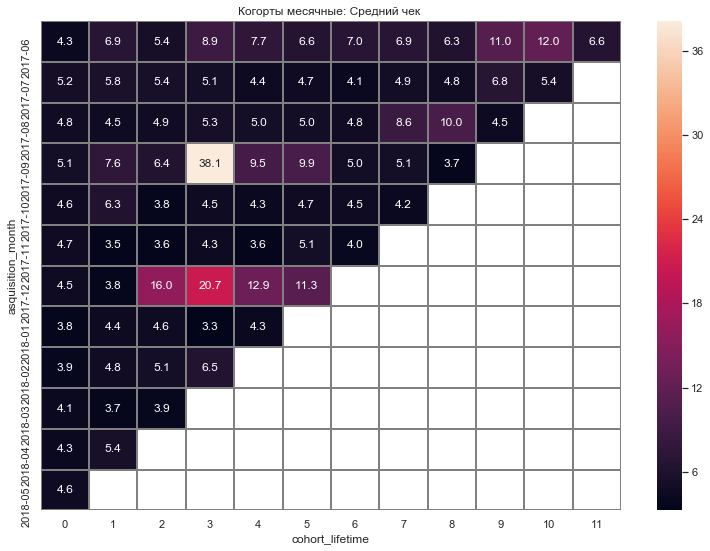

In [83]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты месячные: Средний чек ')
ax = sns.heatmap(revenue_per_user_pivot, annot=True,  fmt='.1f' , linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

In [84]:
#сгруппируем заказы по когортам(тип устройства)
orders_grouped_by_device = report.reset_index().groupby(['device', 'cohort_lifetime']).agg({'revenue':'sum','buy_ts':'nunique'})

In [85]:
#средний чек
orders_grouped_by_device['revenue_per_user'] = orders_grouped_by_device['revenue'] / orders_grouped_by_device['buy_ts']

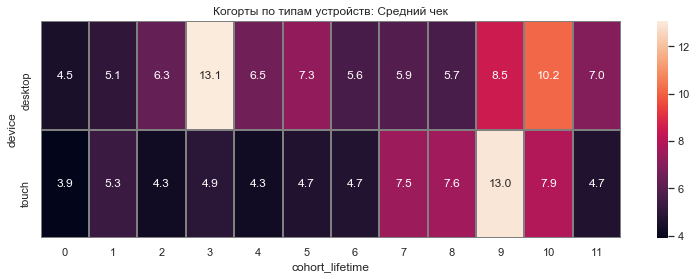

In [86]:
revenue_per_user_pivot_device = orders_grouped_by_device.pivot_table(index='device',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')
sns.set(style='white')
plt.figure(figsize=(13, 4))
plt.title('Когорты по типам устройств: Средний чек')
ax = sns.heatmap(revenue_per_user_pivot_device, annot=True,  fmt='.1f' , linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

In [87]:
#сгруппируем заказы по когортам(рекламный источник)
orders_grouped_by_source_id = report.reset_index().groupby(['source_id', 'cohort_lifetime']).agg({'revenue':'sum','buy_ts':'nunique'})

In [88]:
#средний чек
orders_grouped_by_source_id['revenue_per_user'] = orders_grouped_by_source_id['revenue'] / orders_grouped_by_source_id['buy_ts']

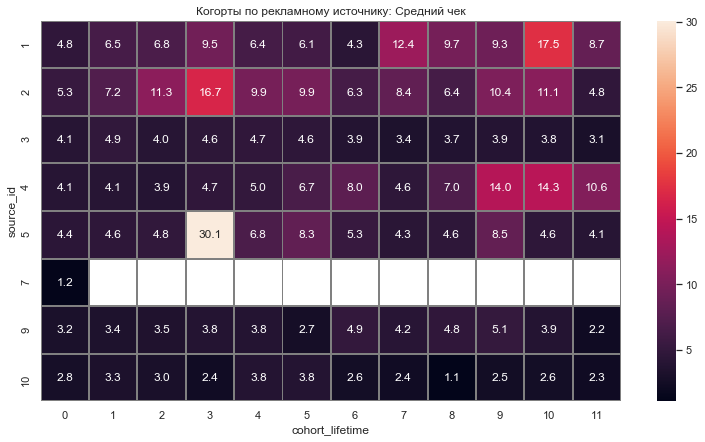

In [89]:
revenue_per_user_pivot_source_id = orders_grouped_by_source_id.pivot_table(index='source_id',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')
sns.set(style='white')
plt.figure(figsize=(13, 7))
plt.title('Когорты по рекламному источнику: Средний чек')
ax = sns.heatmap(revenue_per_user_pivot_source_id, annot=True,  fmt='.1f' , linewidths=1, linecolor='gray')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5);

Анализируя средний чек по когортам обнаружилась интересная особенность. Во многих когортах по месяцам  идет увеличение среднего чека с каждым месяцем активности клиента на сайте и в некоторых случаях очень заметно. То есть несмотря на то, что в количественном измерении людей приходит меньше повторно, те кто возвращается совершают более дорогие покупки.

Средний чек на разных типах устройств тоже отличается. Можно выделить значительный пик с августа по ноябрь с телефонов, и в апреле и ноябре с компьютеров.
Эта информация довольна интересна, возможно в летнее и весеннее время люди больше пользуются телефонами, а не компьютерами.

Средний чек 1,2 и 4 источника наиболее высокий. И не наблюдается зависимости от возраста когорты.


## Расчет LTV и CAC <a class="ancor" id="Шаг_224"></a>

Также рассчитаем данные показатели по 3 типам когорты:
- по месяцам прихода пользователя на сайт
- по типам устройств
- по рекламным источникам

Также необходимо определиться с периодом для анализа. В нашем случае у нас данные за один год, но если смотреть на месячные когорты, то только одна когорта просуществовала год. Для анализа всех когорт рассмотрим их за 6 месяцев жизни когорты

In [90]:
#расчитываем когорты по месяцам

cohorts = (users.groupby('asquisition_month')
           .agg({'payer':'sum', 'asquisition_cost':'sum'}).rename(columns={'payer':'cohort_size'}))
cohorts['cac'] = cohorts['asquisition_cost'] /  cohorts['cohort_size']
cohorts

,cohort_size,asquisition_cost,cac
asquisition_month,,,
2017-06-01,2923.0,18015.00,6.163189
2017-07-01,2458.0,18230.81,7.416928
2017-08-01,1721.0,14789.17,8.593359
2017-09-01,3058.0,24360.36,7.966109
2017-10-01,4678.0,36322.88,7.764617
2017-11-01,4262.0,37907.88,8.894388
2017-12-01,4074.0,38306.03,9.402560
2018-01-01,3119.0,33518.52,10.746560
2018-02-01,3186.0,32707.71,10.266073


In [91]:
ltv_month = report.groupby(['asquisition_month','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

In [92]:
ltv_month = ltv_month.merge(cohorts, on='asquisition_month')

In [93]:
ltv_month['ltv'] = ltv_month['revenue'] / ltv_month['cohort_size']

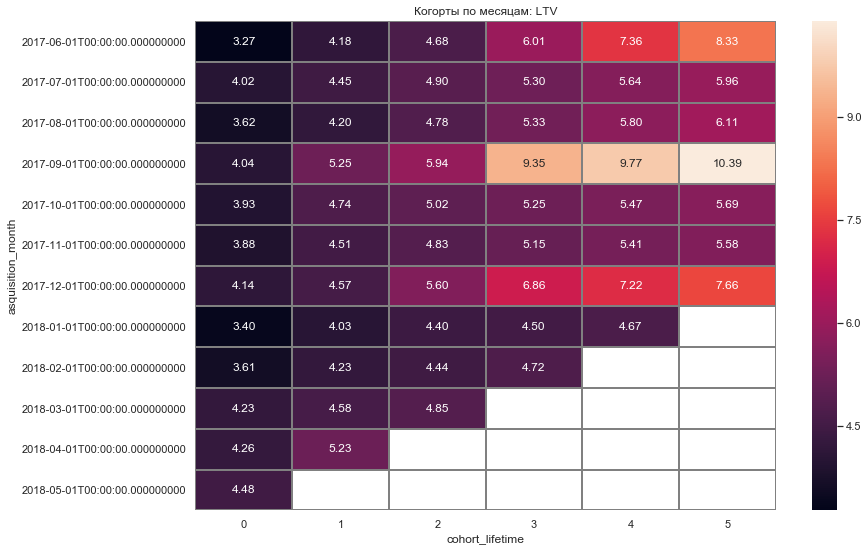

In [94]:
#наконец, посчитаем LTV каждой когорты с каждым месяцем ее жизни
    
output = ltv_month.pivot_table(
        index='asquisition_month', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
    
output.fillna('')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты по месяцам: LTV')
ax = sns.heatmap(output.cumsum(axis=1)[range(0,6)], annot=True,  fmt='.2f' , linewidths=1, linecolor='gray')

i, k = ax.get_ylim()

ax.set_ylim(i+0.5, k-0.5);

In [95]:
m6_cum_ltv = output.mean(axis=0).cumsum()[5]
print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)

Средний LTV за 6 месяцев после первой покупки: 6.8248683261183265


Итак, больше всего дохода принесли 3 когорты: это покупатели, которые пришли в июне 2017 г. и сентябре 2017. и декабре 2017 г.
LTV на графике накопительный.
Cреднемесячный доход когорты за полгода составил 6,8
Чтобы реклама окупилась за полгода, нужно тратить на привлечение одного покупателя в среднем не больше 6,9  в месяц.
Но как мы видим, одни когорты принесли доход почти в 2 раза больше. То есть стоит посмотреть, какой рекламный источник приносит больше дохода.

In [96]:
#по типам устройств
ltv_device = report.groupby(['device','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

In [97]:
cohorts_device = (users.groupby('device')
           .agg({'payer':'sum', 'asquisition_cost':'sum'}).rename(columns={'payer':'cohort_size'}))
cohorts_device['cac'] = cohorts_device['asquisition_cost'] /  cohorts_device['cohort_size']
cohorts_device

,cohort_size,asquisition_cost,cac
device,,,
desktop,29215.0,235069.325005,8.046186
touch,7308.0,93997.154995,12.862227


In [98]:
ltv_device = ltv_device.merge(cohorts_device, on='device')

In [99]:
ltv_device['ltv'] = ltv_device['revenue'] / ltv_device['cohort_size']

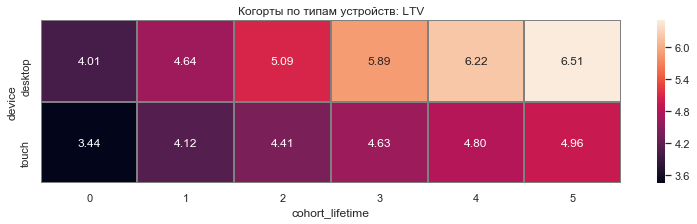

In [100]:
#посчитаем LTV по типам устройств
    
output_device = ltv_device.pivot_table(
        index='device', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
    
output_device.fillna('')

sns.set(style='white')
plt.figure(figsize=(13, 3))
plt.title('Когорты по типам устройств: LTV')
ax = sns.heatmap(output_device.cumsum(axis=1)[range(0,6)], annot=True,  fmt='.2f' , linewidths=1, linecolor='gray')

i, k = ax.get_ylim()

ax.set_ylim(i+0.5, k-0.5);

In [101]:
#по рекламным источникам
ltv_source_id = report.groupby(['source_id','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

In [102]:
cohorts_source_id = (users.groupby('source_id')
           .agg({'payer':'sum', 'asquisition_cost':'sum'}).rename(columns={'payer':'cohort_size'}))
cohorts_source_id['cac'] = cohorts_source_id['asquisition_cost'] /  cohorts_source_id['cohort_size']
cohorts_source_id

,cohort_size,asquisition_cost,cac
source_id,,,
1,2920.0,20833.27,7.134682
2,3497.0,42806.04,12.240789
3,10464.0,141321.63,13.505507
4,10280.0,61073.60,5.941012
5,6960.0,51756.40,7.436264
6,0.0,0.00,NaN
7,1.0,0.00,0.000000
9,1074.0,5454.42,5.078603
10,1327.0,5821.12,4.386677


In [103]:
ltv_source_id = ltv_source_id.merge(cohorts_source_id, on='source_id')

In [104]:
ltv_source_id['ltv'] = ltv_source_id['revenue'] / ltv_source_id['cohort_size']

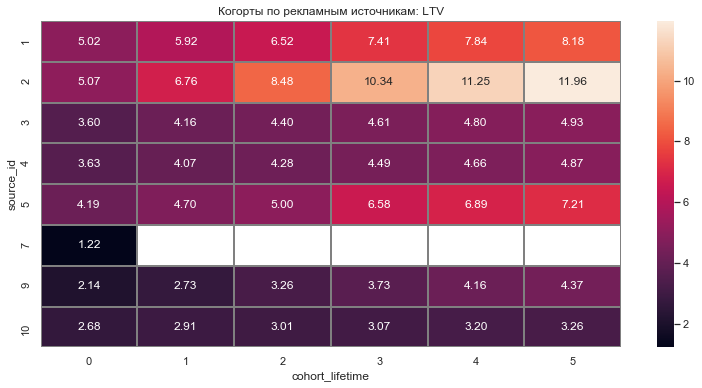

In [105]:
#посчитаем LTV каждой когорты рекламного источника
    
output_device_source_id = ltv_source_id.pivot_table(
        index='source_id', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
    
output_device_source_id.fillna('')

sns.set(style='white')
plt.figure(figsize=(13, 6))
plt.title('Когорты по рекламным источникам: LTV')
ax = sns.heatmap(output_device_source_id.cumsum(axis=1)[range(0,6)], annot=True,  fmt='.2f' , linewidths=1, linecolor='gray')

i, k = ax.get_ylim()

ax.set_ylim(i+0.5, k-0.5);

LTV пользователей компьютеров больше, чем пользователей телефонов, но темпы прироста с каждым месяцем схожи.

Из рекламных источников наибольший доход принесли источники: 1,2 и 5

## Анализ маркетинга  <a class="ancor" id="Шаг_23"></a>

## Общие расходы <a class="ancor" id="Шаг_231"></a>

In [106]:
#посмотрим какие суммарные расходы были за весь период

print('Всего за период было потрачено {:.2f}'.format(costs.costs.sum()))

Всего за период было потрачено 329131.62


In [107]:
#расходы по рекламным источникам
costs_source_id = costs.groupby('source_id').sum().sort_values(by = 'costs',ascending = False)
costs_source_id

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


In [108]:
#в таблице с визитами мы смотрели какой источник приносит больше всего пользователей, сравним эти показатели с расходами
visit_source_id = visits.groupby('source_id')['uid'].nunique().reset_index().sort_values('uid', ascending = False)
costs_source_id = pd.merge(costs_source_id, visit_source_id, on ='source_id')
costs_source_id['costs_per_user'] = costs_source_id['costs'] / costs_source_id['uid']

In [109]:
costs_source_id

,source_id,costs,uid,costs_per_user
0,3,141321.63,74756,1.890439
1,4,61073.60,83525,0.731201
2,5,51757.10,56974,0.908434
3,2,42806.04,26245,1.631017
4,1,20833.27,18999,1.096546
5,10,5822.49,8067,0.721766
6,9,5517.49,9264,0.595584


Мы видим, что расходы на рекламный источник 3 самые большие, но больше всего пользователей пришло из 4 источника. 

Ранее мы уже подсчитали CAC по когортам. 

## CAC <a class="ancor" id="Шаг_232"></a>

In [110]:
# помесячные когорты
cohorts

,cohort_size,asquisition_cost,cac
asquisition_month,,,
2017-06-01,2923.0,18015.00,6.163189
2017-07-01,2458.0,18230.81,7.416928
2017-08-01,1721.0,14789.17,8.593359
2017-09-01,3058.0,24360.36,7.966109
2017-10-01,4678.0,36322.88,7.764617
2017-11-01,4262.0,37907.88,8.894388
2017-12-01,4074.0,38306.03,9.402560
2018-01-01,3119.0,33518.52,10.746560
2018-02-01,3186.0,32707.71,10.266073


In [111]:
#по типам устройств
cohorts_device

,cohort_size,asquisition_cost,cac
device,,,
desktop,29215.0,235069.325005,8.046186
touch,7308.0,93997.154995,12.862227


In [112]:
#по рекламным источникам
cohorts_source_id

,cohort_size,asquisition_cost,cac
source_id,,,
1,2920.0,20833.27,7.134682
2,3497.0,42806.04,12.240789
3,10464.0,141321.63,13.505507
4,10280.0,61073.60,5.941012
5,6960.0,51756.40,7.436264
6,0.0,0.00,NaN
7,1.0,0.00,0.000000
9,1074.0,5454.42,5.078603
10,1327.0,5821.12,4.386677


## На сколько окупились расходы? (ROI) <a class="ancor" id="Шаг_233"></a>

Зная LTV и САС каждого пользователя, можно подсчитать на сколько окупились расходы.

In [113]:
#ROI (месяцы)
ltv_month['roi'] = ltv_month['ltv'] / ltv_month['cac']

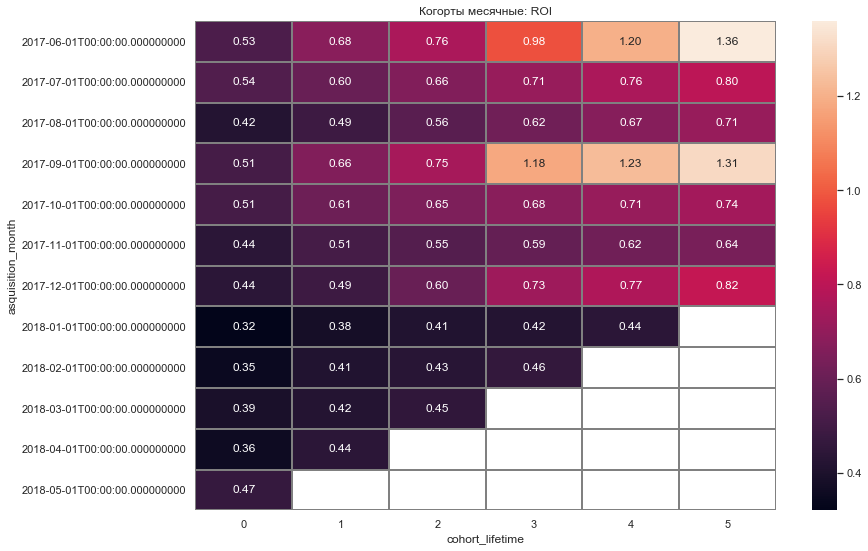

In [114]:
#Рассчитаем ROI: поделим LTV на CAC

roi = ltv_month.pivot_table(
        index='asquisition_month', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean').round(2)
    
roi.fillna('')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты месячные: ROI')
ax = sns.heatmap(roi.cumsum(axis=1)[range(0,6)], annot=True,  fmt='.2f' , linewidths=1, linecolor='gray')

i, k = ax.get_ylim()

ax.set_ylim(i+0.5, k-0.5);

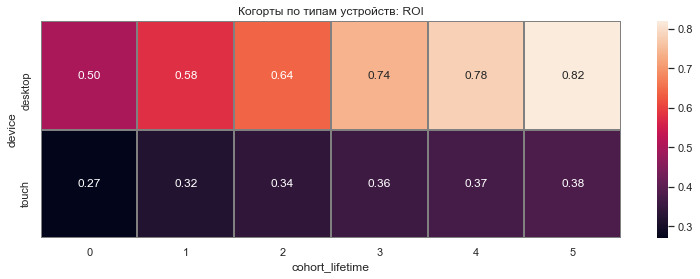

In [115]:
#по типам устройств
ltv_device['roi'] = ltv_device['ltv'] / ltv_device['cac']


roi_device = ltv_device.pivot_table(
        index='device', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean').round(2)
    
roi_device.fillna('')

sns.set(style='white')
plt.figure(figsize=(13, 4))
plt.title('Когорты по типам устройств: ROI')
ax = sns.heatmap(roi_device.cumsum(axis=1)[range(0,6)], annot=True,  fmt='.2f' , linewidths=1, linecolor='gray')

i, k = ax.get_ylim()

ax.set_ylim(i+0.5, k-0.5);

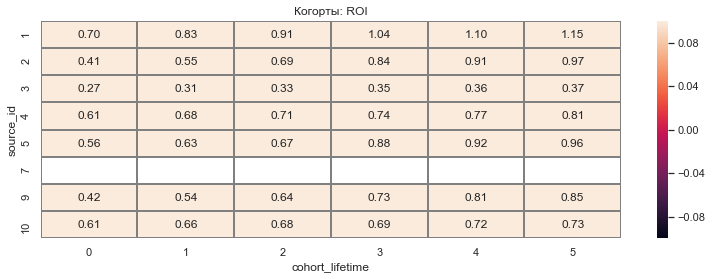

In [118]:
#по рекламным источникам
ltv_source_id['roi'] = ltv_source_id['ltv'] / ltv_source_id['cac']


roi_source_id = ltv_source_id.pivot_table(
        index='source_id', 
        columns='cohort_lifetime', 
        values='roi', 
        aggfunc='mean').round(2)
    
roi_source_id.fillna('')

sns.set(style='white')
plt.figure(figsize=(13, 4))
plt.title('Когорты: ROI')
ax = sns.heatmap(roi_source_id.cumsum(axis=1)[range(0,6)], annot=True,  fmt='.2f' , linewidths=1, linecolor='gray')

i, k = ax.get_ylim()

ax.set_ylim(i+0.5, k-0.5);

За полгода окупились лишь 2 когорты по месяцам: это когорта июня 2017 г., сентября 2017г. Близка к окупаемости июльская и декабрьская когорта, и вероятнее всего если посмотреть на весь срок жизни, то мы увидим что она окупилась на 7 месяце жизни.

Можно сделать вывод, что в июне и сентябре наиболее активные пользователи по покупкам. 

Когорта пользователей телефонов окупается медленно, за 6 месяцев показатель всего 0,38. Следовательно, рентабельнее вкладываться в рекламу на компьютерах.

Рекламные источники почти все окупаются за полгода. Исключение 3 источник, реклама на нем неэффективна.

# Рекомендации маркетологам <a class="ancor" id="Шаг_3"></a>

Проанализировав основные бизнес-показатели Яндекс.Афиши можно подвести вывод и дать рекомендации по оптимизации расходов маркетингового отдела.  

1. Анализ продукта показал, люди все же до сих пор дольше проводят время за компьютером для выбора билетов на различные мероприятия.   
   Это говорит о том, что и реклама будет эффективнее для пользователей декстопа. 
   Стоит учесть этот момент при составление рекламного бюджета.
   
   

2. В канун нового года наблюдается повышенная активность пользователя, данный период можно отнести к горячему сезону.   
   Расходы на клиентов в этот период окупаются очень быстро. Также удачным периодом является лето и конец осени.



3. Показатель удержания клиента на низком уровне, в среднем в когорте повторно возвращаются до 10% от когорты.   
   Возможно, различные стимулирующие к повторной покупке мероприятия могли бы увеличить данный показатель.



4. Между тем средний чек покупателя выше с каждым месяцем жизненного цикла. Это значит, что повысив количество повторных покупок можно значительно увеличить прибыль с одного пользователя.



5. LTV и ROI пользователя показал, несмотря на то, что Retention Rate невысокий, реклама по многим когортам окупается сразу же при первой покупке. 

    Стоит лишь внимательнее отнестить к источникам рекламы и проанализировать их отдельно, например 6 и 7 источник почти не принесли пользователей и покупок.  
    
    5 источник принес очень мало визитов, но все они быстро окупились. Значит нужно увеличить бюджет по данному источнику.
    
    2 источник быстро окупается и от него высокое количество визитов на сайт.  
    
    При этом больше всего пользователей принесли источники 3 и 2. А LTV по ним кардинально отличается. 3 источник не окупается даже при большом количестве визитов на сайт. Возможно реклама не эффективна.

